In [1]:
%cd ~/Projects/mos

/Users/adrienbiarnes/Projects/mos


In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import defaultdict
from typing import Dict, List, Tuple
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
from mos.train.config import Config
from mos.train.datasets import get_data

In [4]:
config = Config({
    "data_dir": "data",
    "gcs_dir": "gs://ml-25m",
    "batch_size": 512,
})
data = get_data(config)

2023-07-18 16:49:32.766010: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-07-18 16:49:32.766032: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-07-18 16:49:32.766040: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-07-18 16:49:32.766071: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-18 16:49:32.766089: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
def compute_positive_predictions(filepath: str, nb_test_obs: int) -> pd.DataFrame:
    results = defaultdict(list)
    with tf.io.gfile.GFile(filepath) as f:
        # We skip the header
        _ = f.readline()
        for i_obs, line in tqdm(enumerate(f.readlines()), total=nb_test_obs):
            preds = line.split(",")
            prev_target = preds[0]
            target = preds[1]

            predictions = np.array(preds[2:])
            repeated_target = np.tile(target, 100)
            is_positive = (repeated_target == predictions).sum() > 0

            results["prev_label"].append(prev_target)
            results["label"].append(target)
            results["is_positive"].append(is_positive)

    return pd.DataFrame(results, columns=["prev_label", "label", "is_positive"])

In [7]:
pred_df_vanilla_32 = compute_positive_predictions("gs://ml-25m/results/predictions_vanilla-sm_32.csv", data.nb_test)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2982016/2982077 [01:03<00:00, 47249.54it/s]


In [8]:
pred_df_mos_32 = compute_positive_predictions("gs://ml-25m/results/predictions_mos_4_32.csv", data.nb_test)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2982016/2982077 [01:03<00:00, 47313.33it/s]


In [9]:
pred_df_vanilla_64 = compute_positive_predictions("gs://ml-25m/results/predictions_vanilla-sm_64.csv", data.nb_test)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2982016/2982077 [01:00<00:00, 49142.69it/s]


In [10]:
pred_df_mos_64 = compute_positive_predictions("gs://ml-25m/results/predictions_mos_4_64.csv", data.nb_test)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2982016/2982077 [01:03<00:00, 46959.73it/s]


In [11]:
pred_df_vanilla_128 = compute_positive_predictions("gs://ml-25m/results/predictions_vanilla-sm_128.csv", data.nb_test)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2982016/2982077 [01:02<00:00, 47891.71it/s]


In [12]:
pred_df_mos_128 = compute_positive_predictions("gs://ml-25m/results/predictions_mos_4_128.csv", data.nb_test)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2982016/2982077 [01:02<00:00, 47565.74it/s]


In [13]:
def compute_metrics_by_view_count_buckets(pred_df: pd.DataFrame, movie_id_counts: Dict[str, int], quantiles: List[float] = None) -> pd.DataFrame:
    """
    Compute metrics with a breakdown by views count
    :param pred_df: The predictions on the evaluation dataset
    :param movie_id_counts: A dictionary with the number of observations to be found in the training dataset for any movie
    """
    def get_count(movie_id):
        return movie_id_counts.get(str(movie_id), 0)

    pred_df["views_count"] = np.vectorize(get_count)(pred_df["label"]).astype(np.int32)
    
    if not quantiles:
        quantiles = [0, .25, .5, .75, 1.]
    pred_df["views_count_bin"] = pd.qcut(pred_df["views_count"], quantiles, precision=0)
    
    def restyle_bin(b):
        if b.left < 0:
            return pd.Interval(0, int(b.right), closed="both")
        return pd.Interval(int(b.left), int(b.right), closed="right")
    pred_df["views_count_bin"] = pred_df["views_count_bin"].apply(restyle_bin)

    metrics_by_views_bucket = defaultdict(list)
    views_count_bins = sorted(pred_df["views_count_bin"].unique())
    for i_bin, views_count_bin in enumerate(views_count_bins):
        pred_bin = pred_df[pred_df["views_count_bin"] == views_count_bin]
        metrics_by_views_bucket["views_count_bin"].append(views_count_bin)
        metrics_by_views_bucket["views_count"].append(len(pred_bin))
        metrics_by_views_bucket["Recall@100"].append(pred_bin["is_positive"].sum() / len(pred_bin))

    return pd.DataFrame(metrics_by_views_bucket)

In [14]:
def compute_all_metrics_by_view_counts(pred_df_list: List[Tuple[pd.DataFrame, str]], quantiles: List[float] = None):
    all_metrics_dfs = []
    for pred_df, sm_name in pred_df_list:
        metrics_by_nb_views_df = compute_metrics_by_view_count_buckets(pred_df, data.movie_id_counts, quantiles)
        metrics_by_nb_views_df["softmax_type"] = sm_name
        all_metrics_dfs.append(metrics_by_nb_views_df)

    return pd.concat(all_metrics_dfs)

In [15]:
pred_df_list = [
    (pred_df_vanilla_32, "vanilla-32"),
    (pred_df_mos_32, "mos-32"),
    (pred_df_vanilla_64, "vanilla-64"),
    (pred_df_mos_64, "mos-64"),
    (pred_df_vanilla_128, "vanilla-128"),
    (pred_df_mos_128, "mos-128"),
]
metrics_by_nb_views_df = compute_all_metrics_by_view_counts(pred_df_list, quantiles=[0, 1])

In [16]:
metrics_by_nb_views_df[["softmax_type", "Recall@100"]]

,softmax_type,Recall@100
0,vanilla-32,0.836285
0,mos-32,0.837041
0,vanilla-64,0.854066
0,mos-64,0.856911
0,vanilla-128,0.865628
0,mos-128,0.868344


In [19]:
recall_32_vanilla = metrics_by_nb_views_df.loc[metrics_by_nb_views_df["softmax_type"] == "vanilla-32", "Recall@100"].values[0]
recall_32_mos = metrics_by_nb_views_df.loc[metrics_by_nb_views_df["softmax_type"] == "mos-32", "Recall@100"].values[0]
recall_64_vanilla = metrics_by_nb_views_df.loc[metrics_by_nb_views_df["softmax_type"] == "vanilla-64", "Recall@100"].values[0]
recall_64_mos = metrics_by_nb_views_df.loc[metrics_by_nb_views_df["softmax_type"] == "mos-64", "Recall@100"].values[0]
recall_128_vanilla = metrics_by_nb_views_df.loc[metrics_by_nb_views_df["softmax_type"] == "vanilla-128", "Recall@100"].values[0]
recall_128_mos = metrics_by_nb_views_df.loc[metrics_by_nb_views_df["softmax_type"] == "mos-128", "Recall@100"].values[0]

increase_32 = ((recall_32_mos - recall_32_vanilla) / recall_32_vanilla) * 100
increase_64 = ((recall_64_mos - recall_64_vanilla) / recall_64_vanilla) * 100
increase_128 = ((recall_128_mos - recall_128_vanilla) / recall_128_vanilla) * 100
print(f"increase_32: {increase_32:.3f}")
print(f"increase_64: {increase_64:.3f}")
print(f"increase_128: {increase_128:.3f}")

increase_32: 0.090
increase_64: 0.333
increase_128: 0.314


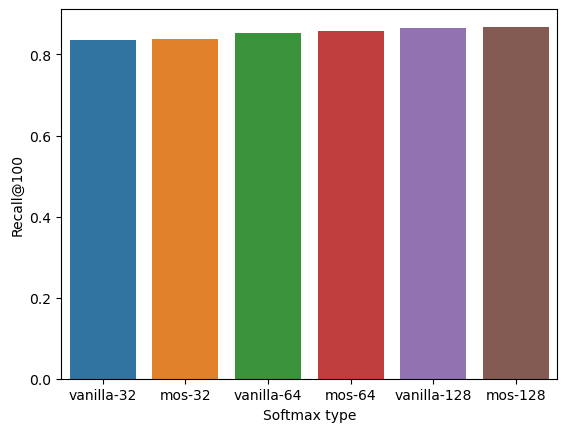

In [20]:
ax=sns.barplot(data=metrics_by_nb_views_df, x="softmax_type", y="Recall@100")
ax.set_xlabel("Softmax type")
ax.figure.savefig("recall-per-softmax-type-and-dim.png")

In [21]:
metrics_by_nb_views_df = compute_all_metrics_by_view_counts(pred_df_list)

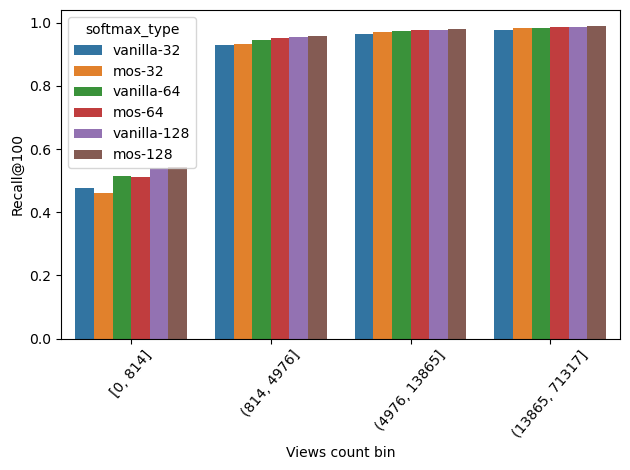

In [22]:
ax=sns.barplot(data=metrics_by_nb_views_df, x="views_count_bin", y="Recall@100", hue="softmax_type")
ax.set_xlabel("Views count bin")
plt.xticks(rotation=50)
plt.tight_layout()
ax.figure.savefig("recall-breakdown-by-nb-obs.png")

In [23]:
import pickle
import tensorflow as tf
sims_np = pickle.load(tf.io.gfile.GFile("gs://ml-25m/movie_sims_matrix.p", "rb"))

In [24]:
sims_np

array([[1.      , 0.2502  , 0.243   , ..., 0.00379 , 0.00379 , 0.00379 ],
       [0.2502  , 1.      , 0.6875  , ..., 0.01226 , 0.01226 , 0.01226 ],
       [0.243   , 0.6875  , 0.9995  , ..., 0.012764, 0.012764, 0.012764],
       ...,
       [0.00379 , 0.01226 , 0.012764, ..., 1.      , 1.      , 1.      ],
       [0.00379 , 0.01226 , 0.012764, ..., 1.      , 1.      , 1.      ],
       [0.00379 , 0.01226 , 0.012764, ..., 1.      , 1.      , 1.      ]],
      dtype=float16)

In [25]:
ratings_df = pd.read_csv("gs://ml-25m/ratings.csv", sep=",", encoding="unicode_escape")

In [26]:
first_test_timestamp = 1499856234
train_ratings_df = ratings_df[ratings_df["timestamp"] < first_test_timestamp]
train_ratings_df = train_ratings_df[train_ratings_df["rating"] >= 2]

In [27]:
train_ratings_df.nunique()

userId         147150
movieId         39803
rating              7
timestamp    16258109
dtype: int64

In [28]:
movie_2_idx = {movie_id: idx for idx, movie_id in enumerate(train_ratings_df["movieId"].unique())}

In [29]:
def compute_metrics_by_movie_distance_buckets(pred_df: pd.DataFrame,
                                              movie_sims_mat: np.array,
                                              movie_2_idx: Dict[int, int]) -> pd.DataFrame:
    """
    Compute metrics with a breakdown by views count
    :param pred_df: The predictions on the evaluation dataset
    :param movie_id_counts: A dictionary with the number of observations to be found in the training dataset for any movie
    """
    def get_distance(prev_movie_id, movie_id):
        if prev_movie_id not in movie_2_idx or movie_id not in movie_2_idx:
            return 1.0
        prev_movie_idx = movie_2_idx[prev_movie_id]
        movie_idx = movie_2_idx[movie_id]
        return 1.0 - movie_sims_mat[prev_movie_idx, movie_idx]

    pred_df["movies_distance"] = np.vectorize(get_distance)(pred_df["prev_label"].astype(int), pred_df["label"].astype(int)).astype(np.float32)

    quantiles = [0, .25, .5, .75, 1.]
    pred_df["movies_distance_bin"] = pd.qcut(pred_df["movies_distance"], quantiles, precision=2)
    
    def restyle_bin(b):
        if b.left < 0:
            return pd.Interval(0, b.right, closed="both")
        return b
    pred_df["movies_distance_bin"] = pred_df["movies_distance_bin"].apply(restyle_bin)

    metrics_by_bucket = defaultdict(list)
    movies_distance_bins = sorted(pred_df["movies_distance_bin"].unique())
    for i_bin, movies_distance_bin in enumerate(movies_distance_bins):
        pred_bin = pred_df[pred_df["movies_distance_bin"] == movies_distance_bin]
        metrics_by_bucket["movies_distance_bin"].append(movies_distance_bin)
        metrics_by_bucket["views_count"].append(len(pred_bin))
        metrics_by_bucket["Recall@100"].append(pred_bin["is_positive"].sum() / len(pred_bin))

    return pd.DataFrame(metrics_by_bucket)

In [30]:
metrics_by_movies_distance_df_vanilla_32 = compute_metrics_by_movie_distance_buckets(pred_df_vanilla_32, sims_np, movie_2_idx)
metrics_by_movies_distance_df_mos_32 = compute_metrics_by_movie_distance_buckets(pred_df_mos_32, sims_np, movie_2_idx)
metrics_by_movies_distance_df_vanilla_64 = compute_metrics_by_movie_distance_buckets(pred_df_vanilla_64, sims_np, movie_2_idx)
metrics_by_movies_distance_df_mos_64 = compute_metrics_by_movie_distance_buckets(pred_df_mos_64, sims_np, movie_2_idx)
metrics_by_movies_distance_df_vanilla_128 = compute_metrics_by_movie_distance_buckets(pred_df_vanilla_128, sims_np, movie_2_idx)
metrics_by_movies_distance_df_mos_128 = compute_metrics_by_movie_distance_buckets(pred_df_mos_128, sims_np, movie_2_idx)

In [31]:
metrics_by_movies_distance_df_vanilla_32["softmax_type"] = "vanilla-32"
metrics_by_movies_distance_df_mos_32["softmax_type"] = "mos-32"
metrics_by_movies_distance_df_vanilla_64["softmax_type"] = "vanilla-64"
metrics_by_movies_distance_df_mos_64["softmax_type"] = "mos-64"
metrics_by_movies_distance_df_vanilla_128["softmax_type"] = "vanilla-128"
metrics_by_movies_distance_df_mos_128["softmax_type"] = "mos-128"
metrics_by_movies_distance_df = pd.concat((
    metrics_by_movies_distance_df_vanilla_32,
    metrics_by_movies_distance_df_mos_32,
    metrics_by_movies_distance_df_vanilla_64,
    metrics_by_movies_distance_df_mos_64,
    metrics_by_movies_distance_df_vanilla_128,
    metrics_by_movies_distance_df_mos_128,
))

In [32]:
metrics_by_movies_distance_df

,movies_distance_bin,views_count,Recall@100,softmax_type
0,"[0, 0.66]",746613,0.976231,vanilla-32
1,"(0.66, 0.78]",744874,0.960043,vanilla-32
2,"(0.78, 0.89]",745296,0.916392,vanilla-32
3,"(0.89, 1.0]",745233,0.492266,vanilla-32
0,"[0, 0.66]",746613,0.981162,mos-32
1,"(0.66, 0.78]",744874,0.965281,mos-32
2,"(0.78, 0.89]",745296,0.919031,mos-32
3,"(0.89, 1.0]",745233,0.482477,mos-32
0,"[0, 0.66]",746613,0.985057,vanilla-64
1,"(0.66, 0.78]",744874,0.971787,vanilla-64


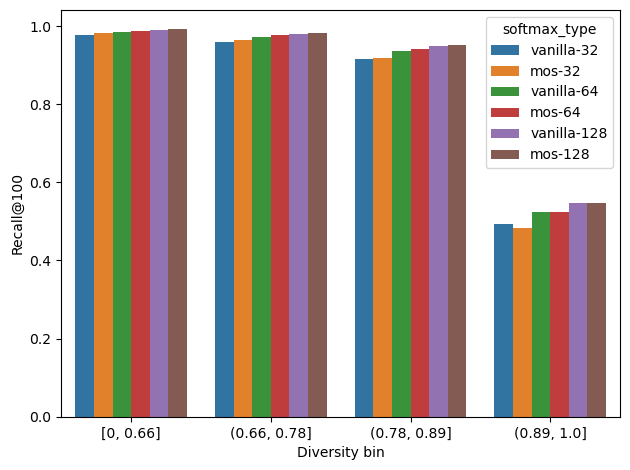

In [33]:
ax = sns.barplot(data=metrics_by_movies_distance_df, x="movies_distance_bin", y="Recall@100", hue="softmax_type")
ax.set_xlabel("Diversity bin")
plt.tight_layout()
ax.figure.savefig("recall-breakdown-by-diversity.png")

In [34]:
def compute_pivot_metrics(pred_df):
    metrics_by_bucket = defaultdict(list)
    movies_distance_bins = sorted(pred_df["movies_distance_bin"].unique())
    views_count_bins = sorted(pred_df["views_count_bin"].unique())
    
    for i_bin, movies_distance_bin in enumerate(movies_distance_bins):
        for j_bin, views_count_bin in enumerate(views_count_bins):
            dist_bin_predicate = pred_df["movies_distance_bin"] == movies_distance_bin
            views_bin_predicate = pred_df["views_count_bin"] == views_count_bin
            pred_bin = pred_df[dist_bin_predicate & views_bin_predicate]
            metrics_by_bucket["movies_distance_bin"].append(movies_distance_bin)
            metrics_by_bucket["views_count_bin"].append(views_count_bin)
            metrics_by_bucket["views_count"].append(len(pred_bin))
            metrics_by_bucket["Recall@100"].append(pred_bin["is_positive"].sum() / len(pred_bin))

    metrics_df = pd.DataFrame(metrics_by_bucket)
    metrics_pivot_df = pd.pivot_table(metrics_df,
                                      values='Recall@100',
                                      index=['movies_distance_bin'],
                                      columns=['views_count_bin'])

    return metrics_pivot_df

In [35]:
metrics_pivot_df_vanilla_32 = compute_pivot_metrics(pred_df_vanilla_32)
metrics_pivot_df_mos_32 = compute_pivot_metrics(pred_df_mos_32)
metrics_pivot_df_vanilla_64 = compute_pivot_metrics(pred_df_vanilla_64)
metrics_pivot_df_mos_64 = compute_pivot_metrics(pred_df_mos_64)
metrics_pivot_df_vanilla_128 = compute_pivot_metrics(pred_df_vanilla_128)
metrics_pivot_df_mos_128 = compute_pivot_metrics(pred_df_mos_128)

In [36]:
improvements_metrics_df_32 = ((metrics_pivot_df_mos_32 - metrics_pivot_df_vanilla_32) / metrics_pivot_df_vanilla_32) * 100
improvements_metrics_df_32

views_count_bin,"[0, 814]","(814, 4976]","(4976, 13865]","(13865, 71317]"
movies_distance_bin,,,,
"[0, 0.66]",1.001581,-0.166931,0.395916,0.624993
"(0.66, 0.78]",-2.119825,0.159360,0.855424,0.813707
"(0.78, 0.89]",-1.375775,0.348070,1.327692,0.807076
"(0.89, 1.0]",-4.390183,0.621441,1.401688,0.908680


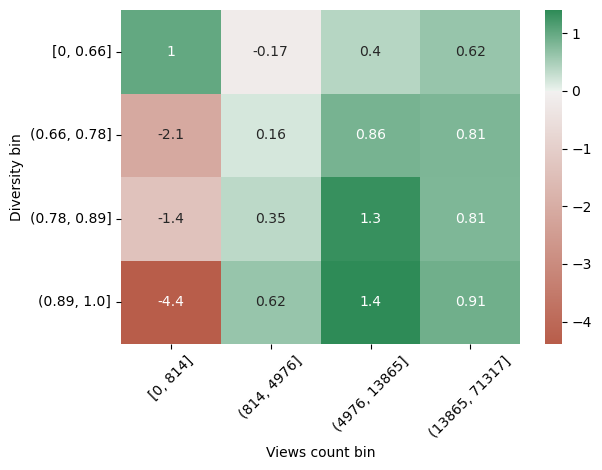

In [258]:
plot_improvements_breakdowns(improvements_metrics_df_32, 32)

In [273]:
improvements_metrics_df_64 = ((metrics_pivot_df_mos_64 - metrics_pivot_df_vanilla_64) / metrics_pivot_df_vanilla_64) * 100

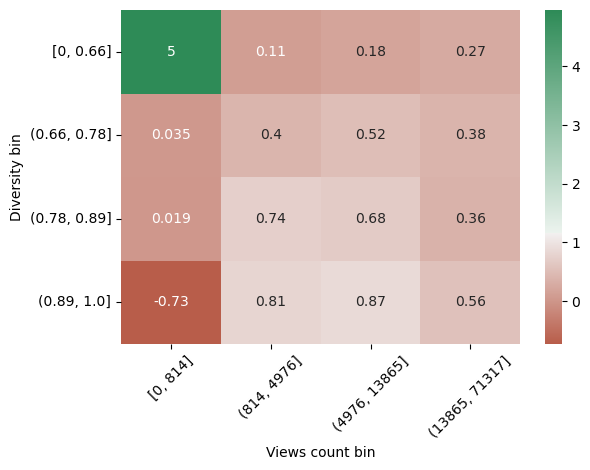

In [274]:
plot_improvements_breakdowns(improvements_metrics_df_64, 64)

In [43]:
def plot_improvements_breakdowns(df: pd.DataFrame, dimension: int):
    cmap = sns.light_palette((20, 60, 50), input="husl", reverse=True, n_colors=1) + \
           sns.light_palette("seagreen", n_colors=600)
    ax = sns.heatmap(df, annot=True, cmap=cmap)
    ax.set_xlabel("Views count bin")
    ax.set_ylabel("Diversity bin")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    ax.figure.savefig(f"recall-breakdown-by-diversity-and-voume-{dimension}.png")

In [44]:
improvements_metrics_df_128 = ((metrics_pivot_df_mos_128 - metrics_pivot_df_vanilla_128) / metrics_pivot_df_vanilla_128) * 100

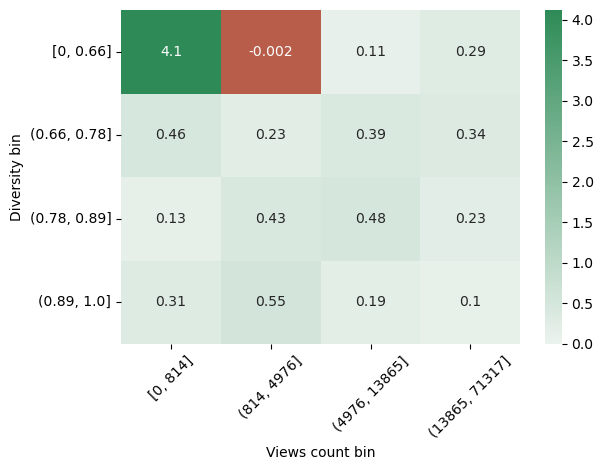

In [46]:
plot_improvements_breakdowns(improvements_metrics_df_128, 128)

In [47]:
pred_df_list = [
    (pred_df_vanilla_32[pred_df_vanilla_32["views_count"] > 814], "vanilla-32"),
    (pred_df_mos_32[pred_df_mos_32["views_count"] > 814], "mos-32"),
    (pred_df_vanilla_64[pred_df_vanilla_64["views_count"] > 814], "vanilla-64"),
    (pred_df_mos_64[pred_df_mos_64["views_count"] > 814], "mos-64"),
    (pred_df_vanilla_128[pred_df_vanilla_128["views_count"] > 814], "vanilla-128"),
    (pred_df_mos_128[pred_df_mos_128["views_count"] > 814], "mos-128"),
]
compute_all_metrics_by_view_counts(pred_df_list, quantiles=[0, 1])

/var/folders/qs/6xx90wmx4y98hnzr7v880j240000gn/T/ipykernel_50500/4043569191.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df["views_count"] = np.vectorize(get_count)(pred_df["label"]).astype(np.int32)
/var/folders/qs/6xx90wmx4y98hnzr7v880j240000gn/T/ipykernel_50500/4043569191.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df["views_count_bin"] = pd.qcut(pred_df["views_count"], quantiles, precision=0)
/var/folders/qs/6xx90wmx4y98hnzr7v880j240000gn/T/ipykernel_50500/4043569191.py:20: Se

,views_count_bin,views_count,Recall@100,softmax_type
0,"(814, 71317]",2236489,0.956524,vanilla-32
0,"(814, 71317]",2236489,0.962439,mos-32
0,"(814, 71317]",2236489,0.967429,vanilla-64
0,"(814, 71317]",2236489,0.971870,mos-64
0,"(814, 71317]",2236489,0.973753,vanilla-128
0,"(814, 71317]",2236489,0.976867,mos-128


In [49]:
increase_32 = ((0.962439 - 0.956524) / 0.956524) * 100
increase_64 = ((0.971870 - 0.967429) / 0.967429) * 100
increase_128 = ((0.976867 - 0.973753) / 0.973753) * 100
print(f"increase_32: {increase_32:.3f}")
print(f"increase_64: {increase_64:.3f}")
print(f"increase_128: {increase_128:.3f}")

increase_32: 0.618
increase_64: 0.459
increase_128: 0.320
